# Hilbert–Huang Transform (HHT)

This notebook presents the data processing with the **Hilbert–Huang Transform (HHT)**, using experimental dataset from **La Roque-Gageac**. Includes steps like:

- **Ensemble Empirical Mode Decomposition (EEMD)**  
- **Hilbert Spectral Analysis**  
- **Result interpretation and visualization**

In [1]:
import os

base_path = r".\Data"

# Lista archivos en el la carpeta data
try:
    files = os.listdir(base_path)
    for file in files:
        print(file)
except FileNotFoundError as e:
    print(f"Directory not found: {base_path}")
except Exception as e:
    print(f"An error occurred: {e}")

IMFs
LARG.dat
LeFauga.dat
SIATA_396.dat
SIATA_532.dat
SIATA_541.dat
SIATA_608.dat
SIATA_613.dat


In [80]:
# La Roque-Gageac data
import numpy as np
import os
from datetime import datetime, timezone

# Parameters
N = 60224    # data length (should match the file length)
dt = 1/24   # timestep in days (1 hour)
T1 = 2010.   # Intial time in decimal years (2010.0)

base_path = r".\Data"
file_name = "LARG.dat"
file_path = os.path.join(base_path, file_name)
data_LARG = np.loadtxt(file_path)

print(f"Data length: {len(data_LARG)}")

# time vector
time = T1 + np.arange(len(data_LARG)) * dt / 365.25

Data length: 60224


In [6]:
# Data
(t, T_a, d_1_6m, d_1_4m,
 d_1_2m, d_2_6m, d_2_4m, d_2_2m, Td_1_6m, Td_1_2m, Td_2_6m, Td_2_2m) = data_LARG.T

# X-axis in datetime format
t_dates = np.array([datetime.fromtimestamp(unix_time, tz=timezone.utc) for unix_time in t])

In [ ]:
import numpy as np
from PyEMD.EEMD import EEMD
import matplotlib.pyplot as plt

# EEMD decomposition
eemd = EEMD(trials=250,noise_width=0.05, parallel=True)
imfs_s_r = eemd(T_a)

# Save IMFs to file
np.savetxt('Data/IMFs/LARG/imfs_T_a_eemd.dat', imfs_s_r)

In [82]:
# Code to plot the imfs and their instantaneous frequencies
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from matplotlib import ticker, dates as mdates
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

# -------- Style  --------
plt.rcParams.update({
    'font.family': 'Times New Roman',  
    'axes.labelweight': 'normal',
    'font.size': 10
})

# -------- Loading Data --------
variable = d_1_6m # Variable to plot
imfs_all = np.loadtxt('.\Data\IMFs\LARG\imfs_d_1_6m_eemd.dat')

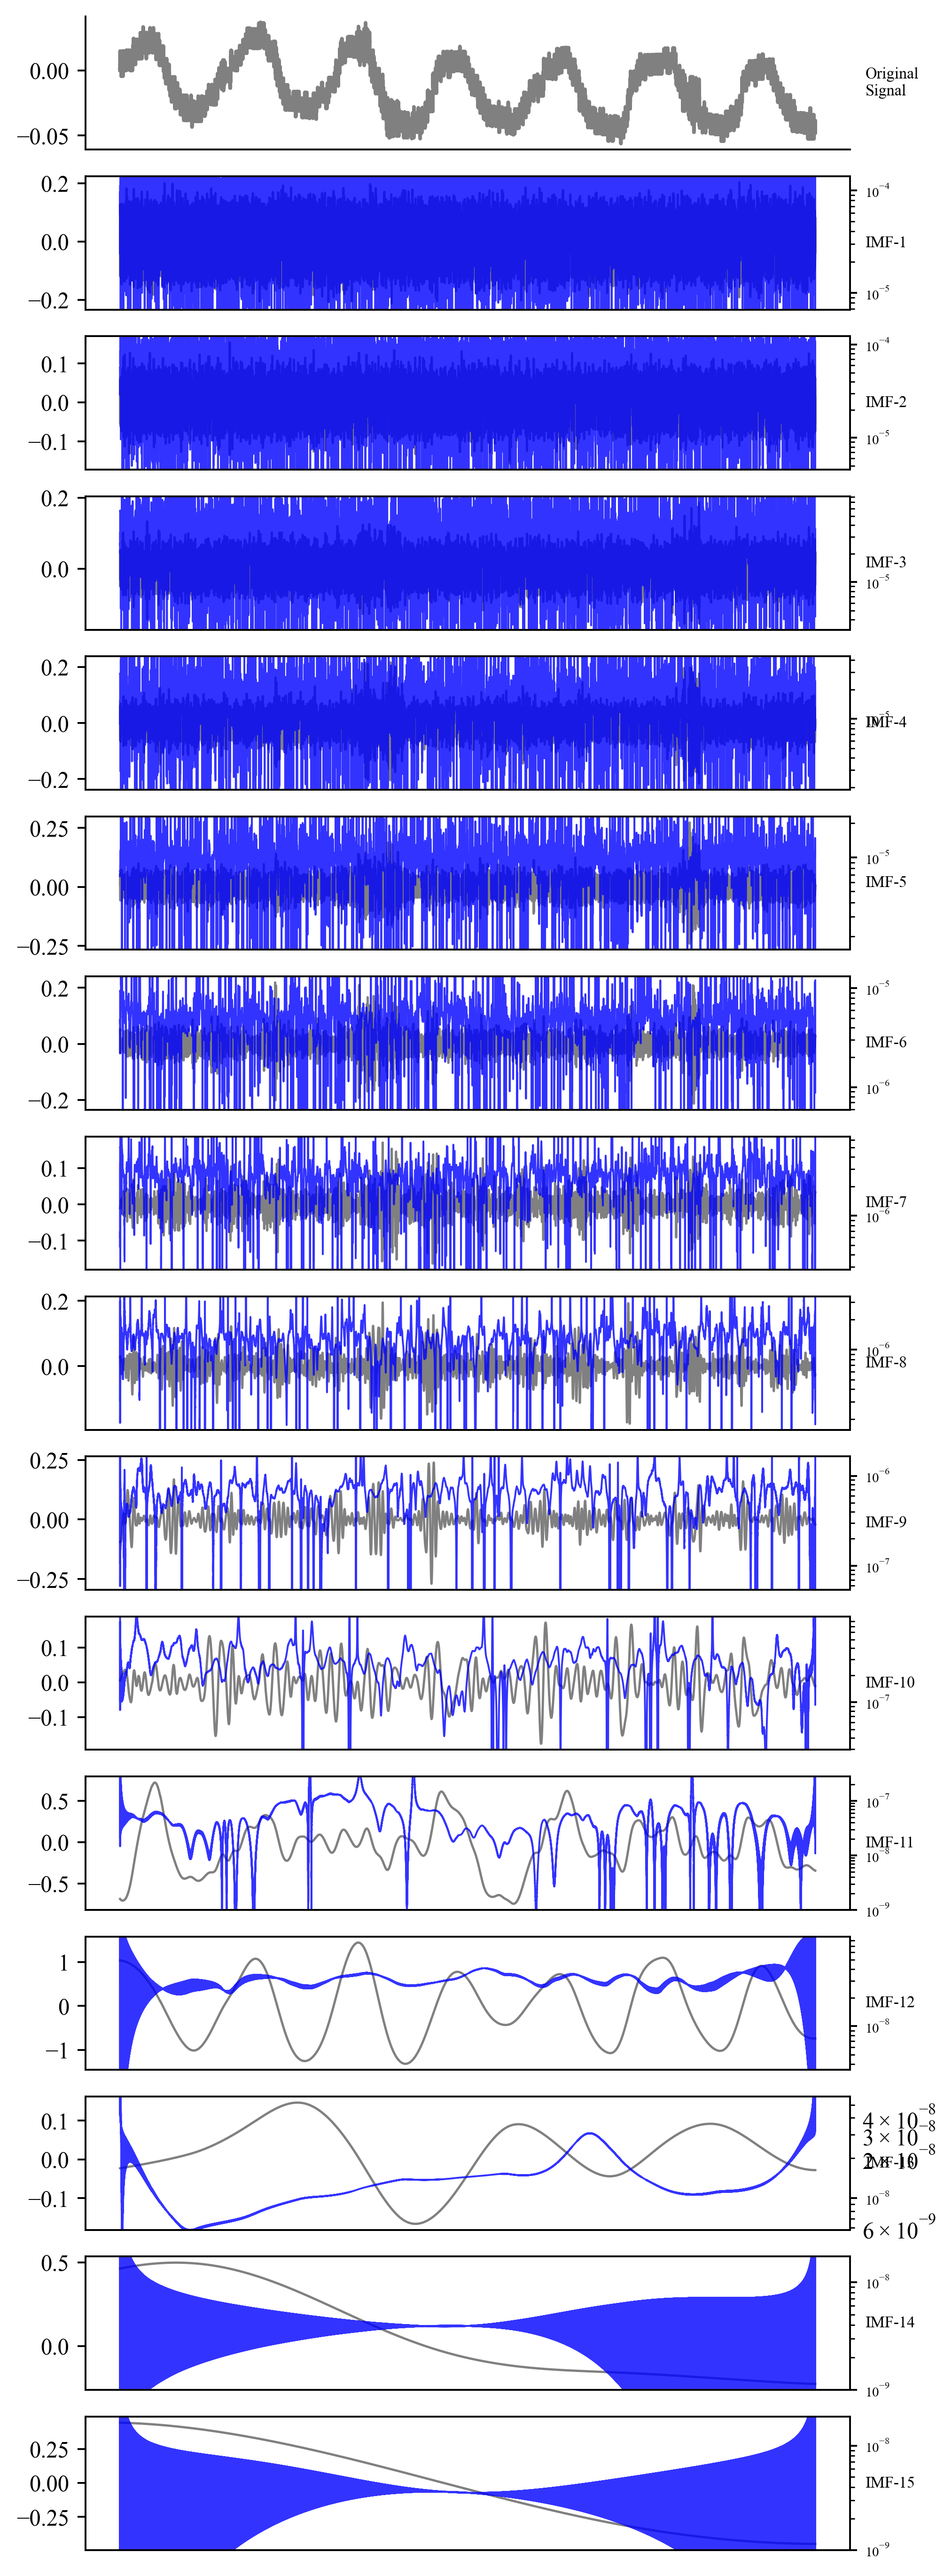

In [83]:

num_imfs = imfs_all.shape[0]
dt_sec = float(np.median(np.diff(mdates.date2num(t_dates))) * 86400.0)  

# -------- Instantaneous Frequency --------
def hilb_freq(s, dt):

    inst_phase = np.unwrap(np.angle(hilbert(s)))
    inst_freq = np.diff(inst_phase) / (2.0 * np.pi * dt) 
    inst_freq = np.abs(inst_freq)  

    return np.concatenate(([inst_freq[0]], inst_freq))

fig, axs = plt.subplots(num_imfs + 1, 1, figsize=(6, 20), dpi=350, sharex=True)

# Orginal signal
axs[0].plot(t_dates, variable, color="gray", lw=1.6)
axs[0].text(1.02, 0.5, "Original\nSignal", va='center', ha='left',
            transform=axs[0].transAxes, fontsize=7)
axs[0].spines[['top','right']].set_visible(False)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot each IMF
for i in range(num_imfs):
    ax = axs[i+1]
    imf = imfs_all[i]
    ax.plot(t_dates, imf, color='gray', lw=1.0)
    ax.text(1.02, 0.5, f'IMF-{i+1}', va='center', ha='left',
            transform=ax.transAxes, fontsize=7)

    f_inst = hilb_freq(imf, dt_sec)
    f_inst = np.abs(f_inst)

    f_pos = f_inst[np.isfinite(f_inst) & (f_inst > 0)]

    ax2 = ax.twinx()
    ax2.set_yscale('log')

    if f_pos.size > 5:
        p1, p99 = np.nanpercentile(f_pos, [1, 99])
        ymin = max(p1, 1e-9)
        ymax = max(p99, ymin * 10)
        ax2.set_ylim(ymin, ymax)
    else:
        ax2.set_ylim(1e-9, 1e-3)

    ax2.plot(t_dates, f_inst, color='blue', lw=0.8, alpha=0.8)

    ax2.yaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,)))
    ax2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10)*0.1))
    ax2.yaxis.set_major_formatter(LogFormatterSciNotation(base=10.0))
    ax2.set_ylabel('', fontsize=6)
    ax2.tick_params(axis='y', labelsize=6, length=3)

    ax.spines[['top','right']].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

In [98]:
## Functions for Hilbert Spectrum Generation

# Hilbert transform to calculate amplitude
def hilb_mod(s):
    return np.abs(hilbert(s))

# Logarithmic scale for frequency with error handling
def log_scale(freq, img_height):
    # Ensure all frequency values are positive and above a small threshold
    mid_val = np.sqrt(1e-8*1e-5) # controls the minimum frequency value
    freq_positive = np.clip(freq, mid_val, np.max(freq))
    freq_log = np.log2(freq_positive)
    return np.interp(freq_log, (min(freq_log), max(freq_log)), (0, img_height - 1)).astype(int)

# Generate Hilbert Spectrum Image
def hilb_spec(s, t, img_height, freq):
    amp = hilb_mod(s)[:-1]
    image = np.zeros((img_height, len(t) // 20 + 1))
    freq_indices = log_scale(freq, img_height)
    t_indices = np.arange(len(freq)) // 20
    image[freq_indices, t_indices] = amp
    return np.flipud(image)

# Generate spectrum for all IMFs
def hilb_spec_imf(imfs, t, img_height, freqs):
    im_fin = np.zeros((img_height, len(t) // 20 + 1)) + 0.01
    for h, f in zip(imfs, freqs):
        im_fin += hilb_spec(h, t, img_height, f)
    return im_fin

# Assuming you have a function to calculate frequency from each IMF
def hilb_freq(s, dt):
    inst_phase = np.unwrap(np.angle(hilbert(s)))
    inst_freq = np.diff(inst_phase) / (2.0 * np.pi) * dt
    return np.abs(inst_freq)

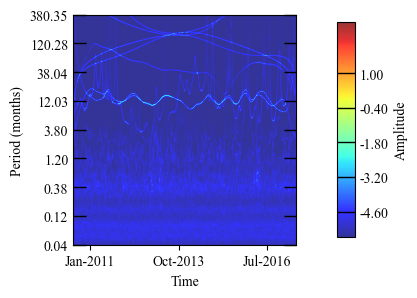

In [100]:
# Code for spectrogram generation
from matplotlib import ticker, dates as mdates
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

# Calculate the frequencies for each IMF
freqs_data = [hilb_freq(imf, dt) for imf in imfs_all]

t = data_LARG[:, 0]  # UNIX time 
t_dates = np.array([datetime.fromtimestamp(unix_time, tz=timezone.utc) for unix_time in t])

# Generate the spectrogram
img_height = 700
spectrogram = hilb_spec_imf(imfs_all, t_dates, img_height, freqs_data)

# Display the spectrogram
fig, ax = plt.subplots(figsize=(4, 4))
cax = ax.imshow(np.log2(spectrogram + 0.01), cmap='jet', aspect=3.7, extent=[t_dates[0], t_dates[-1], 0, img_height], alpha=0.8, interpolation='bilinear')
ticks = np.linspace(-6, 1.0, 6)
cbar = plt.colorbar(cax,aspect=12,pad=0.13,shrink=0.70, ticks=ticks)
cbar.set_label('Amplitude')
cbar.ax.tick_params(direction='in', length=13,width=1)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Yaxis adjustment to show periods in months, between 1e-9 and 1e-3 Hz
all_freqs = np.concatenate(freqs_data)
y_positions = np.linspace(0, img_height, 9)
freq_log_positions = 2**np.linspace(np.log2(1e-09), np.log2(1e-05), 9)
freqs_months = (1 / freq_log_positions) / (86400 * 30.43)  # 30.43 per month
formatted_labels = [f"{m:.2f}" for m in freqs_months]

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3, prune=None))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

ax.tick_params(
    axis='y',
    direction='in',
    which='both',
    right=True,
    length=9,
    width=1.
)

ax.invert_yaxis()

for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')

ax.set_yticks(y_positions)
ax.set_yticklabels(formatted_labels)
plt.xlabel('Time')
plt.ylabel('Period (months)')

#plt.savefig('hilbert_spectrum_1.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
import pandas as pd

# Sampling rate in Hz
rate_hz = 3600
delta_t = 1 / rate_hz  

mean_freq_list = []
periods_days = []
power_percentage = []

# Calculate total energy first
amplitudes = [np.abs(hilbert(imf)) for imf in imfs_all]
energies = [np.sum(amp**2) for amp in amplitudes]
total_energy = sum(energies)

for idx, imf in enumerate(imfs_all, start=1):
    # Mean frequency and period
    analytic_signal = hilbert(imf)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * delta_t
    instantaneous_frequency = np.append(instantaneous_frequency, instantaneous_frequency[-1])
    
    mfq = np.mean(instantaneous_frequency)
    mean_freq_list.append(mfq)
    
    period_days = 1 / mfq / 86400
    periods_days.append(period_days)
    
    # Power percentage of this IMF
    pct_power = (energies[idx - 1] / total_energy) * 100
    power_percentage.append(pct_power)

# DataFrame with IMF as index
df = pd.DataFrame({
    'Mean Frequency (Hz)': mean_freq_list,
    'Period (days)': periods_days,
    'Power (%)': power_percentage
}, index=np.arange(1, len(mean_freq_list) + 1))

df.index.name = "IMF"

# Round only the Hz column to 10 decimals
df['Mean Frequency (Hz)'] = df['Mean Frequency (Hz)'].round(10)

display(df)


,Mean Frequency (Hz),Period (days),Power (%)
IMF,,,
1,6.690800e-05,0.172985,1.656353
2,4.706140e-05,0.245935,0.886727
3,2.574610e-05,0.449546,2.986055
4,1.260530e-05,0.918189,17.659614
5,9.879500e-06,1.171521,3.571066
6,5.138000e-06,2.252620,1.372344
7,2.462800e-06,4.699594,2.244750
8,1.254500e-06,9.226001,2.911341
9,5.765000e-07,20.077203,2.989033
